In [ ]:
Hamza Nashaat Abdelbaki 221100328

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/rating_matrix_rounded_1_to_5 (new).csv')

In [6]:
active_users = ["beatslover21","groovemaster","musicfan92"]

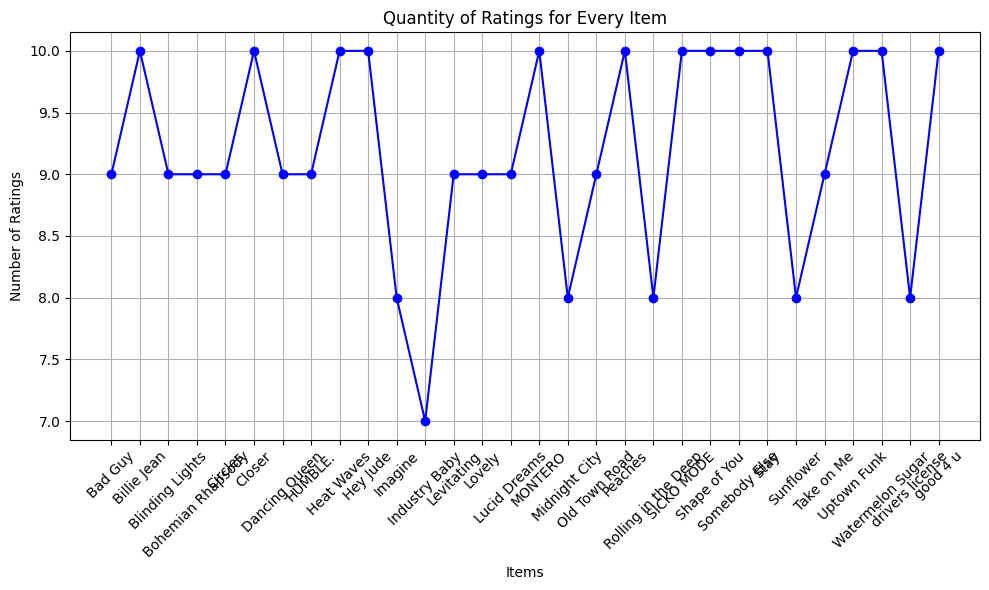

In [8]:
array_data = []
for active_user in active_users:
    active_ratings = df[df["Username"] == active_user].iloc[0, 1:]

    for _, row in df.iterrows():
        if row["Username"] == active_user:
            continue
        other_user = row["Username"]
        other_ratings = row[1:]

        co_rated = (active_ratings != 0) & (other_ratings != 0)
        co_rated_items = co_rated.sum()

        if co_rated_items > 0:
            array_data.append((other_user, co_rated_items))

array_df = pd.DataFrame(array_data, columns=["Common Users", "Co-Rated Items"])
array_df = array_df.groupby("Common Users")["Co-Rated Items"].sum().reset_index()
array_df.sort_values(by="Co-Rated Items", ascending=False, inplace=True)


item_counts = (df.iloc[:, 1:] != 0).sum(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(item_counts.index, item_counts.values, marker="o", linestyle="-", color="b")
plt.title("Quantity of Ratings for Every Item")
plt.xlabel("Items")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
total_items = len(df.columns) - 1

# Calculate 30% of items
threshold_items = np.ceil(0.3 * total_items)
threshold_results = {}

for active_user in active_users:
    active_ratings = df[df["Username"] == active_user].iloc[0, 1:]

    user_counts = 0

    for _, row in df.iterrows():
        if row["Username"] == active_user:
            continue
        other_user = row["Username"]
        other_ratings = row[1:]

        co_rated = (active_ratings != 0) & (other_ratings != 0)
        co_rated_items = co_rated.sum()

        if co_rated_items >= threshold_items:
            user_counts += 1
    threshold_results[active_user] = user_counts
print("Threshold for each active user:")
for user, count in threshold_results.items():
    print(f"{user}: {count} users meet the threshold of {int(threshold_items)} co-rated items")

Threshold (Q) for each active user:
beatslover21: 9 users meet the threshold of 9 co-rated items
groovemaster: 9 users meet the threshold of 9 co-rated items
musicfan92: 9 users meet the threshold of 9 co-rated items


In [10]:
def cosine_similarity(user1, user2):
    common_items = (user1 != 0) & (user2 != 0)
    if common_items.sum() == 0:
        return 0
    u1 = user1[common_items]
    u2 = user2[common_items]
    return np.dot(u1, u2) / (np.sqrt(np.dot(u1, u1)) * np.sqrt(np.dot(u2, u2)))


In [11]:
def pearson_correlation(user1, user2):
    common_items = (user1 != 0) & (user2 != 0)
    if common_items.sum() == 0:
        return 0
    u1 = user1[common_items]
    u2 = user2[common_items]
    mean_u1 = np.mean(u1)
    mean_u2 = np.mean(u2)
    numerator = np.sum((u1 - mean_u1) * (u2 - mean_u2))
    denominator = np.sqrt(np.sum((u1 - mean_u1)**2) * np.sum((u2 - mean_u2)**2))
    return numerator / denominator if denominator != 0 else 0

In [12]:
def mean_centered_ratings(user_ratings):
    mean_rating = np.mean(user_ratings[user_ratings != 0])
    return user_ratings - mean_rating

def calculate_discount_factor(neighbor_ratings, threshold_q=2):
    co_rated_items = sum(1 for rating in neighbor_ratings if rating != 0)
    df = co_rated_items / threshold_q
    return min(df, 1)

In [13]:
def predict_rating(active_user, item, neighbors, df, similarity_func=None, mean_centered=False, threshold_q=2):
    numerator = 0
    denominator = 0
    for neighbor, similarity in neighbors:
        neighbor_ratings = df.loc[neighbor, :]
        if mean_centered:
            neighbor_ratings = mean_centered_ratings(neighbor_ratings)
        if df.loc[neighbor, item] != 0:
            similarity_value = similarity
            if threshold_q:
                df_value = calculate_discount_factor(neighbor_ratings, threshold_q)
                similarity_value *= df_value
            numerator += similarity_value * df.loc[neighbor, item]
            denominator += abs(similarity_value)
    return numerator / denominator if denominator != 0 else 0

In [14]:
def get_top_neighbors(similarity_scores, top_percentage=0.2):
    sorted_neighbors = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_neighbors[:int(len(sorted_neighbors) * top_percentage)]

In [20]:
for active_user in active_users:
    print(f"Predictions for {active_user}:")
    active_ratings = df.loc[active_user]
    similarities = {}
    for user in df.index:
        if user != active_user:
            similarities[user] = cosine_similarity(active_ratings, df.loc[user])
    top_neighbors = get_top_neighbors(similarities, top_percentage=0.2)

    predictions_without_df = {item: predict_rating(active_user, item, top_neighbors, df, similarity_func=cosine_similarity)
                              for item in df.columns if active_ratings[item] == 0}
    print(f"Predicted Ratings (without DF): {predictions_without_df}")

    predictions_with_mean_centering = {item: predict_rating(active_user, item, top_neighbors, df, similarity_func=cosine_similarity, mean_centered=True)
                                       for item in df.columns if active_ratings[item] == 0}
    print(f"Predicted Ratings (with Mean-Centering): {predictions_with_mean_centering}")

    similarities_pcc = {}
    for user in df.index:
        if user != active_user:
            similarities_pcc[user] = pearson_correlation(active_ratings, df.loc[user])

    top_neighbors_pcc = get_top_neighbors(similarities_pcc, top_percentage=0.2)
    predictions_with_pcc = {item: predict_rating(active_user, item, top_neighbors_pcc, df, similarity_func=pearson_correlation)
                            for item in df.columns if active_ratings[item] == 0}
    print(f"Predicted Ratings (using PCC): {predictions_with_pcc}")


Predictions for beatslover21:


KeyError: 'beatslover21'